### GEOGRAPHIC DATA SCIENCE - part 2 - OSM and spatial networks

Guest lecture by Sándor Juhász | [sandorjuhasz.com](sandorjuhasz.com)
<br>


In [6]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx as ox
import networkx as nx 
import matplotlib.pyplot as plt

**Building footprints**

OSM is, in many places, a great resource for data on the built environment. 

To download data on buildings we use `ox.geometries_from_place()` with the **tag dictionary** `"building":True`, which is used to query the OSM data with, and plot them with `ox.plot_footprints()`.

<Axes: >

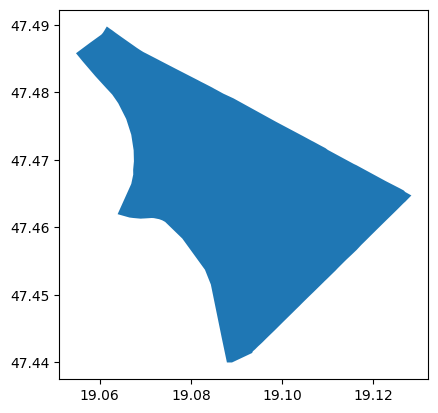

In [2]:
# requrest shape from OSM
district = ox.geocode_to_gdf("9th District, Budapest")
district.plot()

In [3]:
# lets get the building footprint
district_polygon = district.geometry.to_list()[0]
footprint = ox.features_from_polygon(district_polygon, tags = {"building" : True})
len(footprint)

2828

<Axes: >

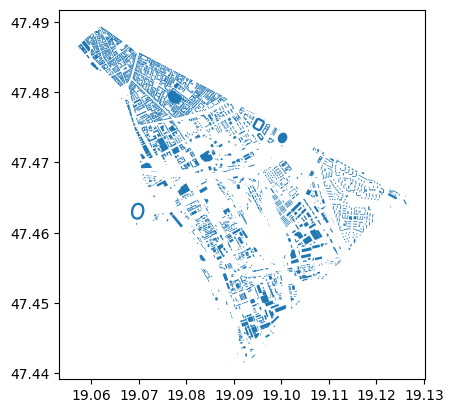

In [4]:
footprint.plot()

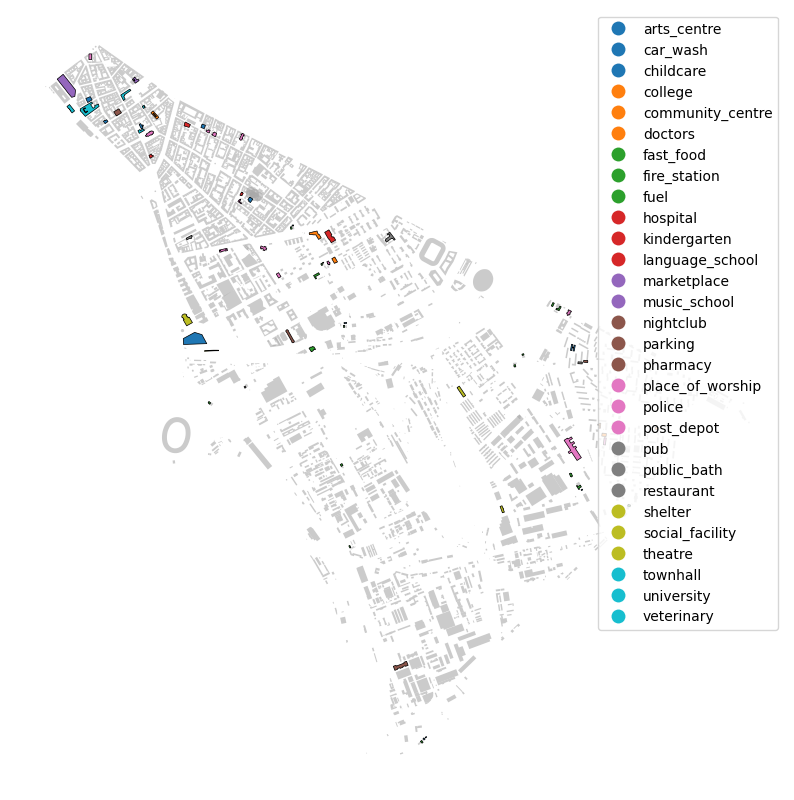

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,12))
crs = 23700

# background layer
footprint.to_crs(crs).plot(
    ax=ax,
    color="darkgrey",
    alpha=0.6,
    linewidth=0.5
)

# main layer with amenities
amenity_plot = footprint.to_crs(crs).plot(
    ax=ax,
    column="amenity",
    cmap="tab10",
    linewidth=0.5,
    edgecolor="black",
    legend=True
)

# legend
legend = amenity_plot.get_figure().axes[-1]  # access the colorbar/legend axis
#legend.set_position([1.05, 0.15, 0.02, 0.7])  # [x, y, width, height] in figure coordinates
ax.set_axis_off()

**Points of interest**

OSM contain a large number of destinations, amenities and other types of 'points of interests' (POIs).

They are - mostly - mapped as point geometries. To get a specific type of POI in e.g. IX. district of Budapest, we can again use `ox.geometries_from_place()` combined with a **tag dictionary**.

Lets download all shops in IX. district, Budapest which have been tagged as 'bakery'.


In [11]:
# define tags used to query OSM
tags = {"shop": "bakery"}  

# download objects that matches query within specific location
bakeries = ox.geometries_from_place(
    ["9th District, Budapest"], tags
)

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_78643/2948113307.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  bakeries = ox.geometries_from_place(


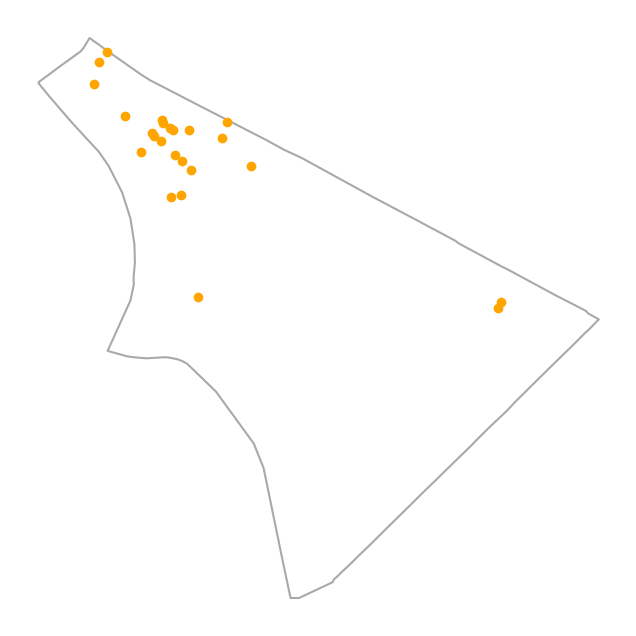

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))

# plot the bakeries
bakeries.to_crs(crs).plot(ax=ax, color="orange", zorder=3)

# add the boundary
district.to_crs(crs).boundary.plot(ax=ax, color="darkgrey", zorder=2)

ax.set_axis_off()

**Street networks**

Street networks is one of the more common types of **spatial networks**. 

There are several different ways of defining which area we want network data for.

For example:

* Use `ox.graph_from_point()` to get the network centered around a specific location, defined by a coordinate pair.

[epsg.io](https://epsg.io/) is a great resource for finding coordinates in different coordinate reference systems (CRS).

OSMnx uses WGS84/EPSG:4326

* Use the parameters `dist` to define the search window around our point

* Set `dist_type = network` to use the distance in network length (compared to a straight "as the crow flies" distance)

* Set `network_type = walk` to only include the part of the street network where walking is allowed

In [23]:
# coordinates of the C building of Corvinus University of Budapest
# notice that the coordinates must be passed as lat, long (y,x)

location_point = (
    47.48498593072006, # lat
    19.060465555108056, # lon
)  

# get graph within 1000 walking network distance of the C building
graph1 = ox.graph_from_point(
    location_point, dist=1000, dist_type="network", network_type="walk" 
)  

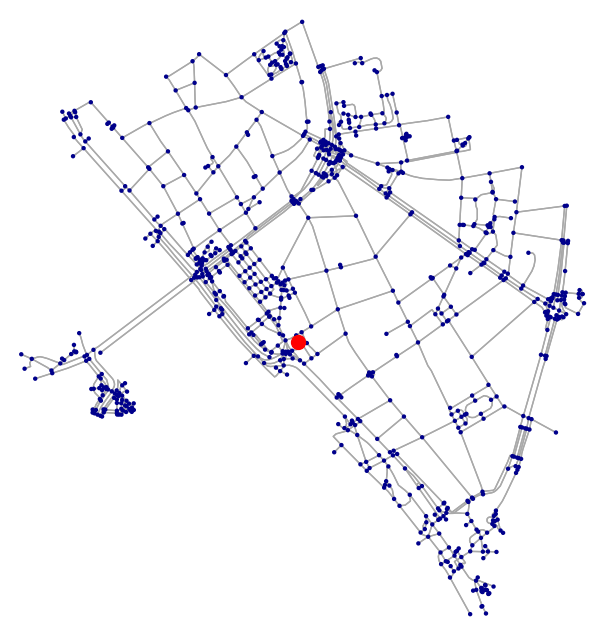

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))

# our point coordinate location - this time lon, lat!
ax.plot(location_point[1], location_point[0], "ro", markersize=10) 

ox.plot_graph(
    graph1, ax=ax, node_color="darkblue", bgcolor="white", edge_color="darkgrey", node_size=10
)

In [43]:
# we can turn nodes and edges to POINT and LINESTRING objects easily
nodes, edges = ox.graph_to_gdfs(graph1)
nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
18590962,47.485218,19.052364,3,NaN,NaN,POINT (19.05236 47.48522)
48833403,47.485782,19.070110,4,NaN,NaN,POINT (19.07011 47.48578)
78053262,47.487254,19.058012,4,crossing,NaN,POINT (19.05801 47.48725)
84677021,47.485036,19.059993,5,NaN,NaN,POINT (19.05999 47.48504)
84677023,47.485415,19.059731,3,NaN,NaN,POINT (19.05973 47.48541)


<Axes: >

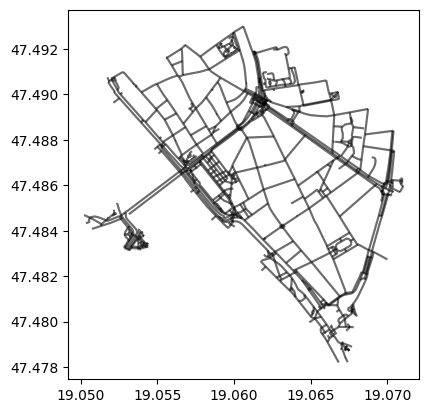

In [48]:
edges.plot(color="black", alpha=0.35)

In [39]:
# network from address, including only nodes within 1km along the network from the address
graph_bike = ox.graph_from_address(
    address="8, Fővám tér, Budapest",
    dist=1000,
    dist_type="network",
    # this time getting all streets and paths where biking is allowed
    network_type="bike"
)

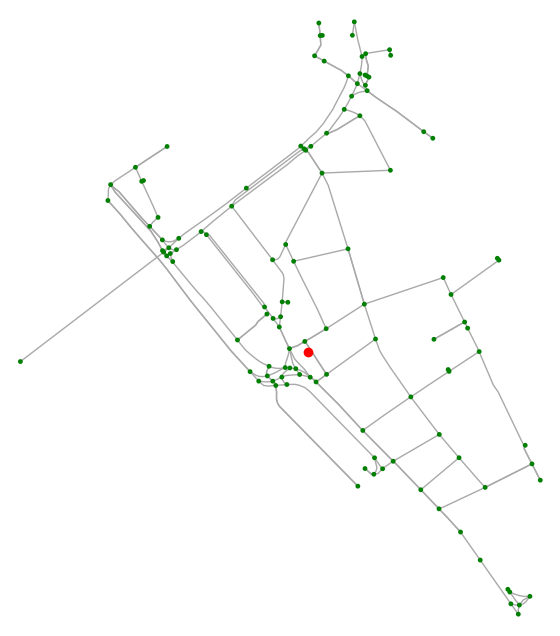

In [40]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))

# our point coordinate location 
ax.plot(location_point[1], location_point[0], "ro") 

ox.plot_graph(
    graph_bike, ax=ax, node_color="green", bgcolor="white", edge_color="darkgrey", node_size=12
);

In [76]:
# get the Budapest metro network
# first we need to add the railway tag as a 'useful tag' to be included by OSMnx
ox.settings.useful_tags_way += [
    "railway"
]

cf = '["railway"~"subway"]'

graph_metro = ox.graph_from_place(
    ["Budapest, Hungary"],
    custom_filter=cf,
    retain_all=True,  # keep all components, not just the largest one
    truncate_by_edge=False,
    simplify=True,
)

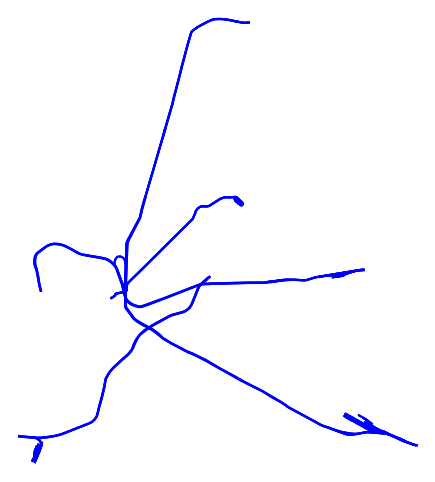

(<Figure size 800x600 with 1 Axes>, <Axes: >)

In [77]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ox.plot_graph(graph_metro, ax=ax, node_size=0, edge_color="b", edge_linewidth=1.5)

In [82]:
# degree table
degree_data = dict(graph_metro.degree)
degree_df = pd.DataFrame(list(degree_data.items()), columns=["osmid", "degree"]).sort_values(by="degree", ascending=False)

# add coordinates
nodes, edges = ox.graph_to_gdfs(graph_metro)
degree_df = pd.merge(
    degree_df,
    nodes,
    on="osmid",
    how="left"
)

In [84]:
# check out the first one on google maps
degree_df.head()

,osmid,degree,y,x,street_count,geometry
0,1019868565,8,47.465501,19.142393,4,POINT (19.14239 47.46550)
1,7057880344,8,47.519610,19.091089,4,POINT (19.09109 47.51961)
2,1978311528,8,47.503757,19.050854,4,POINT (19.05085 47.50376)
3,1103685840,8,47.502577,19.132931,4,POINT (19.13293 47.50258)
4,1019868479,8,47.465851,19.141196,4,POINT (19.14120 47.46585)


In [86]:
# final example -- Debrecen
graph_debrecen = ox.graph_from_place("Debrecen, Hungary", network_type="drive")

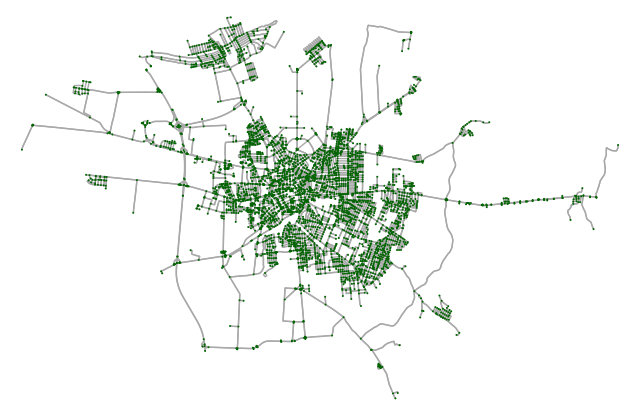

Text(0.5, 1.0, 'Debrecen')

In [92]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ox.plot_graph(
    graph_debrecen, ax=ax, node_color="darkgreen", bgcolor="white", edge_color="darkgrey", node_size=2
)
ax.set_title("Debrecen")

In [96]:
# degree distribution
degree_data = dict(graph_debrecen.degree)
degree_df = pd.DataFrame(list(degree_data.items()), columns=["osmid", "degree"]).sort_values(by="degree", ascending=False)

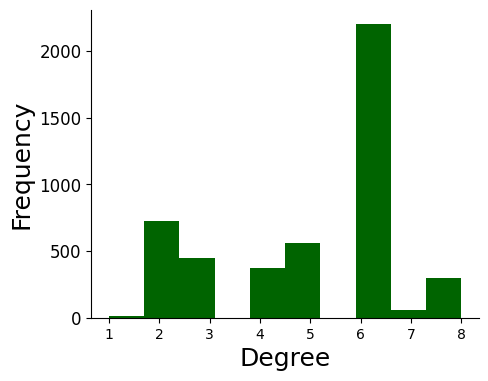

In [104]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.hist(degree_df["degree"], color="darkgreen")
ax.set_xlabel("Degree", size=18)
ax.set_ylabel("Frequency", size=18)
ax.tick_params("y", labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

**Exercise**

Compare the street network of Szeged and Miskolc (or your home town)

**Spatial social networks**

**aggregate Twitter data in Boston and Seattle -- distance decay of social ties**

In [18]:
# data import
nodes = pd.read_csv('/Users/sandorjuhasz/Desktop/RESEARCH-3/05a_highways_social_ties_data/data/twitter_users.csv.gz', header=0)
edges = pd.read_csv('/Users/sandorjuhasz/Desktop/RESEARCH-3/05a_highways_social_ties_data/data/twitter_follower_edges.csv.gz', header=0)

In [19]:
boston_nodes = nodes[nodes["cbsacode"]==14460]
boston_edges = edges[edges["cbsacode"]==14460]

In [20]:
# aggregate to census tracts!
ct_el = boston_edges.groupby(["tract_home1", "tract_home2"]).size().reset_index(name="nr_social_ties")
ct_el.to_csv("../data/boston_US_twitter_edgelist.csv", index=False, sep=";")

In [37]:
ct_el = pd.read_csv("../DATA/boston_US_twitter_edgelist.csv", sep=";")

In [41]:
tract_geoms = gpd.read_file('/Users/sandorjuhasz/Desktop/RESEARCH-3/05a_highways_social_ties_data/data/shapes/census_tracts.shp')
tract_geoms["lat"] = tract_geoms["geometry"].centroid.y
tract_geoms["lon"] = tract_geoms["geometry"].centroid.x
#tract_geoms = tract_geoms[["tract_geoi", "lat", "lon"]].drop_duplicates()
tract_geoms

,aland,awater,display_na,tract_geoi,simple_nam,sumlevel,geometry,lat,lon
0,4655526,11144,"Census Tract 70.02, Bergen, NJ",14000US34003007002,Census Tract 70.02,140,"POLYGON ((-73.96209 40.96961, -73.95826 40.983...",40.972170,-73.948532
1,5365613,19159,"Census Tract 91, Bergen, NJ",14000US34003009100,Census Tract 91,140,"POLYGON ((-73.97598 40.95429, -73.97552 40.957...",40.955033,-73.956779
2,736569,0,"Census Tract 63, Bergen, NJ",14000US34003006300,Census Tract 63,140,"POLYGON ((-73.99830 40.80848, -73.99783 40.809...",40.813834,-73.991320
3,2026199,5573,"Census Tract 152, Bergen, NJ",14000US34003015200,Census Tract 152,140,"POLYGON ((-73.98915 40.90930, -73.98861 40.911...",40.907260,-73.976727
4,3704990,21986,"Census Tract 155, Bergen, NJ",14000US34003015500,Census Tract 155,140,"POLYGON ((-73.98486 40.87487, -73.98450 40.875...",40.879221,-73.970564
...,...,...,...,...,...,...,...,...,...
38783,24416508,0,"Census Tract 2106.03, Guadalupe, TX",14000US48187210603,Census Tract 2106.03,140,"POLYGON ((-98.17081 29.58293, -98.15583 29.590...",29.578149,-98.135219
38784,6596451,104117,"Census Tract 2104, Guadalupe, TX",14000US48187210400,Census Tract 2104,140,"POLYGON ((-97.96369 29.56053, -97.96367 29.561...",29.569990,-97.943230
38785,90253630,224606,"Census Tract 4.01, Medina, TX",14000US48325000401,Census Tract 4.01,140,"POLYGON ((-98.88726 29.16101, -98.87497 29.177...",29.150639,-98.838141
38786,163372265,623058,"Census Tract 1.02, Wilson, TX",14000US48493000102,Census Tract 1.02,140,"POLYGON ((-98.11274 29.28001, -98.11259 29.280...",29.313486,-98.034811


In [39]:
ct_el = pd.merge(
    ct_el,
    tract_geoms,
    left_on="tract_home1",
    right_on="tract_geoi",
    how="left"
)
ct_el = pd.merge(
    ct_el,
    tract_geoms,
    left_on="tract_home2",
    right_on="tract_geoi",
    how="left",
    suffixes=["1", "2"]
)

In [40]:
ct_el

,tract_home1,tract_home2,nr_social_ties,tract_geoi1,lat1,lon1,tract_geoi2,lat2,lon2
0,14000US25009201100,14000US25009201100,8,14000US25009201100,42.428771,-70.925946,14000US25009201100,42.428771,-70.925946
1,14000US25009201100,14000US25009202101,1,14000US25009201100,42.428771,-70.925946,14000US25009202101,42.475573,-70.906775
2,14000US25009201100,14000US25009202102,3,14000US25009201100,42.428771,-70.925946,14000US25009202102,42.481205,-70.918848
3,14000US25009201100,14000US25009203301,1,14000US25009201100,42.428771,-70.925946,14000US25009203301,42.507393,-70.863911
4,14000US25009201100,14000US25009204500,1,14000US25009201100,42.428771,-70.925946,14000US25009204500,42.529924,-70.890694
...,...,...,...,...,...,...,...,...,...
46758,14000US33017088500,14000US33017084300,2,14000US33017088500,43.469217,-71.120004,14000US33017084300,43.308326,-70.971307
46759,14000US33017088500,14000US33017084400,1,14000US33017088500,43.469217,-71.120004,14000US33017084400,43.300467,-70.986329
46760,14000US33017088500,14000US33017084500,2,14000US33017088500,43.469217,-71.120004,14000US33017084500,43.260657,-70.976743
46761,14000US33017088500,14000US33017087000,7,14000US33017088500,43.469217,-71.120004,14000US33017087000,43.362940,-71.075903


In [16]:
tract_geoms

,tract_geoi,geometry
0,14000US34003007002,"POLYGON ((-73.96209 40.96961, -73.95826 40.983..."
1,14000US34003009100,"POLYGON ((-73.97598 40.95429, -73.97552 40.957..."
2,14000US34003006300,"POLYGON ((-73.99830 40.80848, -73.99783 40.809..."
3,14000US34003015200,"POLYGON ((-73.98915 40.90930, -73.98861 40.911..."
4,14000US34003015500,"POLYGON ((-73.98486 40.87487, -73.98450 40.875..."
...,...,...
38783,14000US48187210603,"POLYGON ((-98.17081 29.58293, -98.15583 29.590..."
38784,14000US48187210400,"POLYGON ((-97.96369 29.56053, -97.96367 29.561..."
38785,14000US48325000401,"POLYGON ((-98.88726 29.16101, -98.87497 29.177..."
38786,14000US48493000102,"POLYGON ((-98.11274 29.28001, -98.11259 29.280..."


In [8]:
boston_edges

,cbsacode,user_id1,user_id2,lat_home1,lon_home1,lat_home2,lon_home2,distance_m,tract_home1,tract_home2
498,14460,4678,364,42.421,-71.126,42.369,-71.154,8435,14000US25017339200,14000US25017370300
499,14460,5212,364,42.386,-71.123,42.369,-71.154,4297,14000US25017354500,14000US25017370300
500,14460,794111,364,42.346,-71.077,42.369,-71.154,9245,14000US25025070700,14000US25017370300
501,14460,896221,364,42.347,-71.128,42.369,-71.154,4400,14000US25021400300,14000US25017370300
502,14460,963481,364,42.400,-71.123,42.369,-71.154,5808,14000US25017350500,14000US25017370300
...,...,...,...,...,...,...,...,...,...,...
2710912,14460,167575108,995953854,42.365,-71.018,42.407,-71.059,7803,14000US25025981300,14000US25017342400
2710913,14460,223226315,995953854,42.408,-71.053,42.407,-71.059,684,14000US25017342500,14000US25017342400
2710914,14460,235046871,995953854,42.283,-71.052,42.407,-71.059,18692,14000US25025100700,14000US25017342400
2710915,14460,361659790,995953854,43.136,-70.931,42.407,-71.059,111467,14000US33017080203,14000US25017342400


In [9]:
ct_el[ct_el["tract_home1"]<ct_el["tract_home2"]]

,tract_home1,tract_home2,nr_social_ties
1,14000US25009201100,14000US25009202101,1
2,14000US25009201100,14000US25009202102,3
3,14000US25009201100,14000US25009203301,1
4,14000US25009201100,14000US25009204500,1
5,14000US25009201100,14000US25009205200,2
...,...,...,...
46651,14000US33017084600,14000US33017087000,6
46719,14000US33017085000,14000US33017086000,1
46720,14000US33017085000,14000US33017087000,1
46743,14000US33017087000,14000US33017088000,1
